<h1><center>RECOMMENDER SYSTEMS</center></h1>

In [1]:
#Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Used for getting the song information
import sqlite3

#Used for item-similarity based recommender
from sklearn.model_selection import train_test_split
import Recommenders

#used for sparse matrix and matrix factorisation recommender
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
import math as mt
import csv
from scipy.sparse import csc_matrix 

## Dataset

In [2]:
#Make sure you have train_triplets.txt in the data folder before running this code
filepath = '../data/train_triplets.txt'
triplet_dataset = pd.read_csv(filepath_or_buffer = filepath,header = None,sep = '\t',names = ['user','song','play_count'])

In [3]:
triplet_dataset.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


In [4]:
triplet_dataset.shape

(48373586, 3)

## Exploratory Data Analysis (EDA):


In [5]:
#Determine how many unique users does the dataset have. 
#So we concentrate on users that consitute to a large percentage of play counts
#Due to the large size of the file, we will read it line by line
#We will then extract play count information on a user


output_dict = {}

with open(filepath) as f:
    for line_number,line in enumerate(f):
        user = line.split('\t')[0]
        play_count = int(line.split('\t')[2])
        if user in output_dict:
            play_count += output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
    output_list = [{'user':k,'play_count':v} for k,v in output_dict.items()]
    user_count_df = pd.DataFrame(output_list)
    user_count_df = user_count_df.sort_values(by='play_count',ascending = False)
    user_count_df = user_count_df.reset_index()
    user_count_df.drop(columns = 'index',inplace = True)

In [6]:
user_count_df.head()

,user,play_count
0,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
1,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
2,3fa44653315697f42410a30cb766a4eb102080bb,8210
3,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
4,d7d2d888ae04d16e994d6964214a1de81392ee04,6494


In [7]:
#Determine how many unique songs does the dataset have. 
#So we concentrate on songs that consitute to a large percentage of play counts
#Due to the large size of the file, we will read it line by line
#We will then extract play count information on a song


output_dict = {}

with open(filepath) as f:
    for line_number,line in enumerate(f):
        song = line.split('\t')[1]
        play_count = int(line.split('\t')[2])
        if song in output_dict:
            play_count += output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
    output_list = [{'song':k,'play_count':v} for k,v in output_dict.items()]
    song_count_df = pd.DataFrame(output_list)
    song_count_df = song_count_df.sort_values(by='play_count',ascending = False)
    song_count_df = song_count_df.reset_index()
    song_count_df.drop(columns = 'index',inplace = True)

In [8]:

song_count_df.head()

,song,play_count
0,SOBONKR12A58A7A7E0,726885
1,SOAUWYT12A81C206F1,648239
2,SOSXLTC12AF72A7F54,527893
3,SOFRQTD12A81C233C0,425463
4,SOEGIYH12A6D4FC0E3,389880


In [9]:
user_count_df.shape

(1019318, 2)

In [10]:
song_count_df.shape

(384546, 2)

In [11]:
#Determining Number of users (n) accounting to 40% of play counts
total_play_count = sum(user_count_df.play_count)
(float(user_count_df.head(n=100000).play_count.sum())/total_play_count)*100

40.8807280500655

In [12]:
#Determining Number of songs (n) accounting to 80% of play counts
total_play_count = sum(song_count_df.play_count)
(float(song_count_df.head(n=30000).play_count.sum())/total_play_count)*100

78.39315366645269

In [13]:
#Subsets of users
user_count_subset = user_count_df.head(n=100000)
user_subset = user_count_subset.user

#Subsets of songs
song_count_subset = song_count_df.head(n=30000)
song_subset = song_count_subset.song

In [14]:
#Code to form subsets of with maximum play counts per song and user
triplet_dataset_sub = triplet_dataset[triplet_dataset.user.isin(user_subset)]
del(triplet_dataset)
triplet_dataset_sub_song = triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
triplet_dataset_sub_song = triplet_dataset_sub_song.reset_index()
triplet_dataset_sub_song.drop(columns = 'index',inplace = True)
del(triplet_dataset_sub)

In [15]:
#Final subset
triplet_dataset_sub_song.head()

,user,song,play_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


In [16]:
#Number of rows and columns in final subset containing user,song and play_count combination
triplet_dataset_sub_song.shape

(10774558, 3)

### Enhancing The Data:


In [17]:
conn = sqlite3.connect('../data/track_metadata.db')
cur = conn.cursor()
cur.execute("select name from sqlite_master where type = 'table'")
cur.fetchall()

[('songs',)]

In [18]:
track_metadata_df = pd.read_sql_query("SELECT * from songs", conn)


In [19]:
track_metadata_df.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMMYQ128F932D901,Silent Night,SOQMMHC12AB0180CB8,Monster Ballads X-Mas,ARYZTJS1187B98C555,357ff05d-848a-44cf-b608-cb34b5701ae5,Faster Pussy cat,252.05506,0.649822,0.394032,2003,7032331,-1,0
1,TRMMMKD128F425225D,Tanssi vaan,SOVFVAK12A8C1350D9,Karkuteillä,ARMVN3U1187FB3A1EB,8d7ef530-a6fd-4f8f-b2e2-74aec765e0f9,Karkkiautomaatti,156.55138,0.439604,0.356992,1995,1514808,-1,0
2,TRMMMRX128F93187D9,No One Could Ever,SOGTUKN12AB017F4F1,Butter,ARGEKB01187FB50750,3d403d44-36ce-465c-ad43-ae877e65adc4,Hudson Mohawke,138.97098,0.643681,0.437504,2006,6945353,-1,0
3,TRMMMCH128F425532C,Si Vos Querés,SOBNYVR12A8C13558C,De Culo,ARNWYLR1187B9B2F9C,12be7648-7094-495f-90e6-df4189d68615,Yerba Brava,145.05751,0.448501,0.372349,2003,2168257,-1,0
4,TRMMMWA128F426B589,Tangle Of Aspens,SOHSBXH12A8C13B0DF,Rene Ablaze Presents Winter Sessions,AREQDTE1269FB37231,,Der Mystic,514.29832,0.000000,0.000000,0,2264873,-1,0


In [20]:
track_metadata_df.drop(columns = ['track_id','artist_mbid','artist_id','duration','artist_familiarity','artist_hotttnesss','track_7digitalid','shs_perf','shs_work'],inplace = True)

In [21]:
track_metadata_df = track_metadata_df.drop_duplicates(['song_id'])

In [22]:
triple_dataset_merged = pd.merge(triplet_dataset_sub_song,track_metadata_df,how = 'left',left_on = 'song',right_on = 'song_id')

In [23]:
triple_dataset_merged.head()

,user,song,play_count,title,song_id,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,SOADQPP12A67020C82,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,SOAFTRR12AF72A8D4D,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,SOANQFY12AB0183239,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,SOAYATB12A6701FD50,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),SOBOAFP12A8C131F36,We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


In [24]:
triple_dataset_merged.rename(columns = {'play_count':'listen_count'},inplace  =True)
triple_dataset_merged.drop(columns = ['song_id'],inplace = True)
#Final Dataset
triple_dataset_merged.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


### Visual Analysis

In [46]:
#Number of Unique Users in our dataset
user_len = len(triple_dataset_merged['user'].unique())
user_len

99996

In [47]:
#Number of Unique Songs in our dataset
song_len = len(triple_dataset_merged['song'].unique())
song_len

30000

In [25]:
plt.rcdefaults()
popular_songs = triple_dataset_merged[['title','listen_count']].groupby('title').sum().reset_index()

In [26]:
popular_songs.head()

,title,listen_count
0,I Will Not Reap Destruction,1022
1,!@*$%#,362
2,#!*@ You Tonight [Featuring R. Kelly] (Explici...,695
3,#1,525
4,#1 Stunna,457


In [27]:
popular_songs_top_20 = popular_songs.sort_values('listen_count',ascending = False).head(n=20).reset_index()
popular_songs_top_20.drop(columns = ['index'],inplace  =True)

In [28]:
popular_songs_top_20.head()

,title,listen_count
0,You're The One,249477
1,Undo,191211
2,Revelry,173469
3,Horn Concerto No. 4 in E flat K495: II. Romanc...,124999
4,Sehr kosmisch,124945


In [29]:
objects = list(popular_songs_top_20['title'])
y_pos = np.arange(len(objects))
performance = list(popular_songs_top_20['listen_count'])

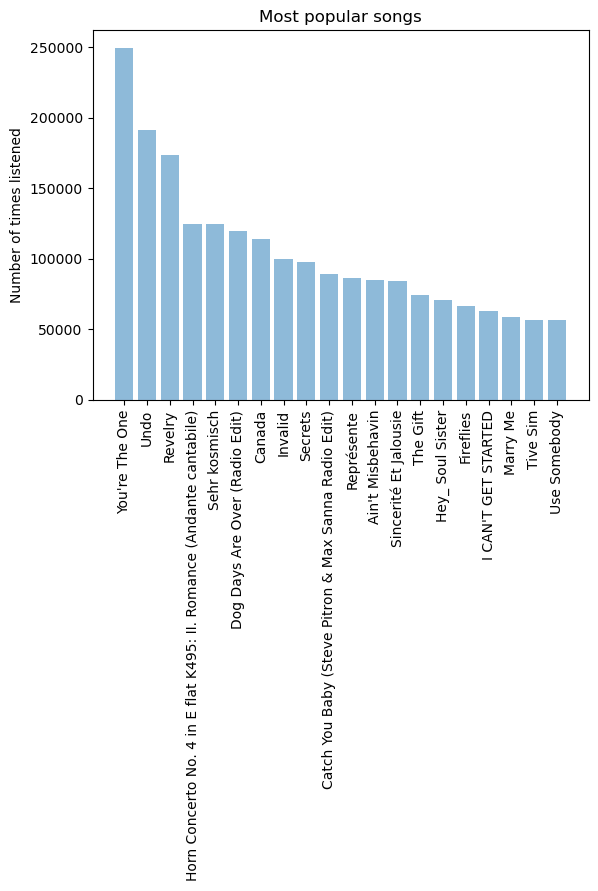

In [30]:
plt.bar(y_pos,performance,align = 'center',alpha = 0.5)
plt.xticks(y_pos,objects,rotation = 'vertical')
plt.ylabel('Number of times listened')
plt.title('Most popular songs')
plt.show()

#### Most Popular Artists

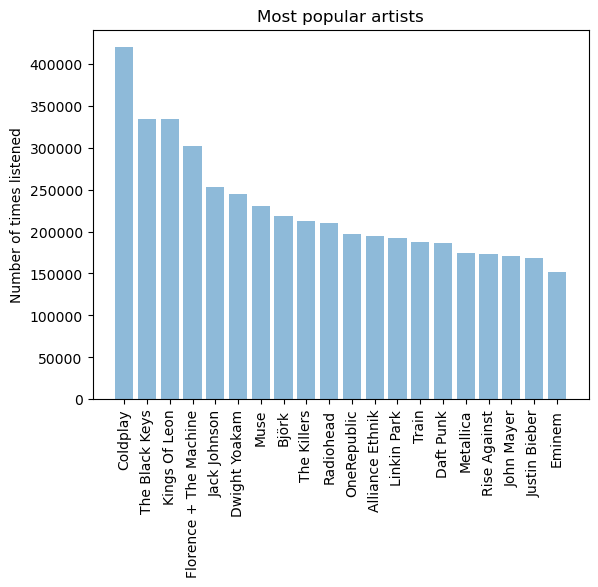

In [31]:
plt.rcdefaults()

popular_artists = triple_dataset_merged[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
popular_artists_top_20 = popular_artists.sort_values('listen_count',ascending = False).head(n=20).reset_index()
popular_artists_top_20.drop(columns = ['index'],inplace  =True)
objects = list(popular_artists_top_20['artist_name'])
y_pos = np.arange(len(objects))
performance = list(popular_artists_top_20['listen_count'])
plt.bar(y_pos,performance,align = 'center',alpha = 0.5)
plt.xticks(y_pos,objects,rotation = 'vertical')
plt.ylabel('Number of times listened')
plt.title('Most popular artists')
plt.show()

### Popularity Based Recommender

In [32]:
def create_popularity_recommendation(train_data,user_id,item_id):
    #Get a count of user_ids for each unique song as recommendation score
    train_data_grouped = train_data.groupby([item_id]).agg({user_id:'count'}).reset_index()
    train_data_grouped.rename(columns = {user_id:'score'},inplace = True)
    
    #Sort the songs based on recommendation score
    train_data_sort = train_data_grouped.sort_values(['score',item_id],ascending = [0,1])
    
    #Generate a recommendation rank based upon score
    train_data_sort['Rank'] = train_data_sort['score'].rank(ascending = 0,method  ='first')
    
    #Get the top 20 recommendations
    popularity_recommendations = train_data_sort.head(20)
    return popularity_recommendations

In [33]:
recommendations = create_popularity_recommendation(triple_dataset_merged,'user','title')
#Recommendations based on most listened song by all users
recommendations

,title,score,Rank
19580,Sehr kosmisch,18626,1.0
5780,Dog Days Are Over (Radio Edit),17635,2.0
27314,You're The One,16085,3.0
19542,Secrets,15138,4.0
18636,Revelry,14945,5.0
25070,Undo,14687,6.0
7530,Fireflies,13085,7.0
9640,Hey_ Soul Sister,12993,8.0
25216,Use Somebody,12793,9.0
9921,Horn Concerto No. 4 in E flat K495: II. Romanc...,12346,10.0


### Item Similarity Based Recommendation Engine

In [34]:
#Subsets of songs
song_count_subset = song_count_df.head(n=5000)
song_subset = song_count_subset.song
triple_dataset_merged_subset = triple_dataset_merged[triple_dataset_merged.song.isin(song_subset)]

In [35]:
#Dataset will contain only most popular songs.
triple_dataset_merged_subset.shape

(5535035, 7)

In [36]:
train_data,test_data = train_test_split(triple_dataset_merged_subset,test_size = 0.3,random_state = 0)
is_model = Recommenders.item_similarity_recommender_py()
is_model.create(train_data,'user','title')

#Change the user_id in the square brackets to get recommendation for any of the 100000 users in the dataset
user_id = list(train_data.user)[7]
user_items = is_model.get_user_items(user_id)
is_model.recommend(user_id)

No. of unique songs for the user: 66
no. of unique songs in the training set: 4879
Non zero values in cooccurence_matrix :290327


,user_id,song,score,rank
0,a974fc428825ed071281302d6976f59bfa95fe7e,Put Your Head On My Shoulder (Album Version),0.026334,1
1,a974fc428825ed071281302d6976f59bfa95fe7e,The Strength To Go On,0.025176,2
2,a974fc428825ed071281302d6976f59bfa95fe7e,Come Fly With Me (Album Version),0.024447,3
3,a974fc428825ed071281302d6976f59bfa95fe7e,Moondance (Album Version),0.024118,4
4,a974fc428825ed071281302d6976f59bfa95fe7e,Kotov Syndrome,0.023311,5
5,a974fc428825ed071281302d6976f59bfa95fe7e,Use Somebody,0.023104,6
6,a974fc428825ed071281302d6976f59bfa95fe7e,Lucky (Album Version),0.022930,7
7,a974fc428825ed071281302d6976f59bfa95fe7e,Secrets,0.022889,8
8,a974fc428825ed071281302d6976f59bfa95fe7e,Clocks,0.022562,9
9,a974fc428825ed071281302d6976f59bfa95fe7e,Sway (Album Version),0.022359,10


### Matrix Factorization Based Recommendation Engine

In [37]:
triple_dataset_merged_sum = triple_dataset_merged[['user','listen_count']].groupby('user').sum().reset_index()
triple_dataset_merged_sum.rename(columns = {'listen_count':'total_listen_count'},inplace = True)
triple_dataset_merged = pd.merge(triple_dataset_merged,triple_dataset_merged_sum)
triple_dataset_merged['fractional_play_count'] = triple_dataset_merged['listen_count']/triple_dataset_merged['total_listen_count']

In [38]:
small_set = triple_dataset_merged
user_codes = small_set.user.drop_duplicates().reset_index()
song_codes = small_set.song.drop_duplicates().reset_index()
user_codes.rename(columns = {'index':'user_index'},inplace = True)
song_codes.rename(columns = {'index':'song_index'},inplace = True)
user_codes['user_index_value'] = list(user_codes.index)
song_codes['song_index_value'] = list(song_codes.index)
small_set = pd.merge(small_set,song_codes,how = 'left')
small_set = pd.merge(small_set,user_codes,how = 'left')
mat_candidate = small_set[['user_index_value','song_index_value','fractional_play_count']]
data_array = mat_candidate.fractional_play_count.values
row_array = mat_candidate.user_index_value.values
col_array = mat_candidate.song_index_value.values
data_sparse = coo_matrix((data_array,(row_array,col_array)),dtype = float)


In [39]:
data_sparse

<99996x30000 sparse matrix of type '<class 'numpy.float64'>'
	with 10774558 stored elements in COOrdinate format>

In [40]:


#Compute SVD of the user ratings matrix
def computeSVD(urm, K):
    U, s, Vt = svds(urm,K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt




In [41]:
K = 50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]
U, S, Vt = computeSVD(urm, K)


In [42]:
uTest = [4]

print("User id for whom recommendations are needed: %d" % uTest[0])


User id for whom recommendations are needed: 4


In [43]:
#Compute estimated rating for the test user
def computeEstimatedRatings(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 

    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        #we convert the vector to dense format in order to get the indices 
        #of the movies with the best estimated ratings 
        estimatedRatings[userTest, :] = prod.todense()
        recom = (-estimatedRatings[userTest, :]).argsort()[:250]
    return recom

In [44]:
#Get estimated rating for test user
print("Predictied ratings:")
uTest_recommended_items = computeEstimatedRatings(urm, U, S, Vt, uTest, K, True)

Predictied ratings:


In [45]:
for user in uTest:
    print("Recommendation for user with user id {}".format(user))
    print("-------------------------------------------------------")
    rank_value = 1
    for i in uTest_recommended_items[0:10]:
        song_details = small_set[small_set.song_index_value == i].drop_duplicates('song_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value,list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1
    print("***********************************************************************************")    

Recommendation for user with user id 4
-------------------------------------------------------
The number 1 recommended song is Fireflies BY Charttraxx Karaoke
The number 2 recommended song is Hey_ Soul Sister BY Train
The number 3 recommended song is OMG BY Usher featuring will.i.am
The number 4 recommended song is Lucky (Album Version) BY Jason Mraz & Colbie Caillat
The number 5 recommended song is Vanilla Twilight BY Owl City
The number 6 recommended song is Crumpshit BY Philippe Rochard
The number 7 recommended song is Billionaire [feat. Bruno Mars]  (Explicit Album Version) BY Travie McCoy
The number 8 recommended song is Love Story BY Taylor Swift
The number 9 recommended song is Jamaica Roots II(Agora E Sempre) BY Natiruts
The number 10 recommended song is Use Somebody BY Kings Of Leon
***********************************************************************************
